In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
misc_df = pd.read_csv("./data/misc_stats.csv")
opponent_per_100_df = pd.read_csv("./data/opponent_per_100_poss.csv")
opponent_shooting_df = pd.read_csv("./data/opponent_shooting.csv")
opponent_stats_df = pd.read_csv("./data/opponent_stats.csv")
opponents_per_game_df = pd.read_csv("./data/opponents_per_game.csv")
team_per_game_df = pd.read_csv("./data/team_per_game.csv")
team_shooting_df = pd.read_csv("./data/team_shooting.csv")
team_stats_df = pd.read_csv("./data/team_stats.csv")
standings_df = pd.read_csv("./data/standings.csv")
team_vs_team_df = pd.read_csv("./data/team_vs_team.csv")

In [28]:
standings_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Place,Place.1,Conference,Conference.1,Division,Division.1,Division.2,...,All-Star,All-Star.1,Margin,Margin.1,Month,Month.1,Month.2,Month.3,Month.4,Month.5
0,Rk,Team,Overall,Home,Road,E,W,A,C,SE,...,Pre,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar
1,1,Milwaukee Bucks,53-12,28-3,25-9,34-5,19-7,9-2,13-1,12-2,...,46-8,7-4,3-1,36-7,2-2,15-1,13-2,11-2,10-1,2-4
2,2,Los Angeles Lakers,49-14,23-8,26-6,16-7,33-7,5-4,4-2,7-1,...,41-12,8-2,5-3,25-7,3-1,14-1,9-5,10-4,9-2,4-1
3,3,Toronto Raptors,46-18,23-9,23-9,30-10,16-8,8-4,12-3,10-3,...,40-15,6-3,6-4,21-9,4-1,10-3,9-7,12-3,7-3,4-1
4,4,Los Angeles Clippers,44-20,25-7,19-13,17-6,27-14,5-2,4-3,8-1,...,37-18,7-2,8-1,29-8,4-2,10-4,10-5,9-4,7-4,4-1


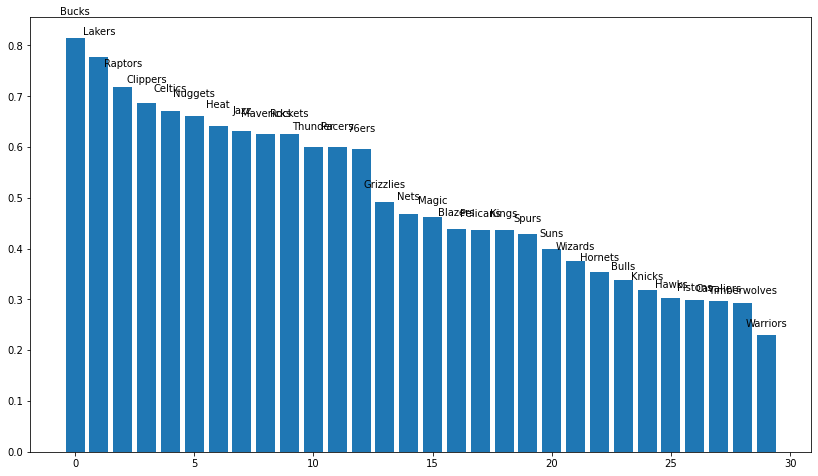

In [90]:
fig, ax = plt.subplots(figsize = (14,8))
nickname = standings_df["Unnamed: 1"].apply(lambda x: x.split()[-1])
record = standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[0]).astype(int) / (standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[0]).astype(int) + standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[1]).astype(int))
x = list(range(30))
rects1 = ax.bar(x, record.sort_values(ascending = False))
def autolabel(rects):
    count = 1
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                nickname[count],
        ha='center', va='bottom')
        count = count + 1
autolabel(rects1)

30
30


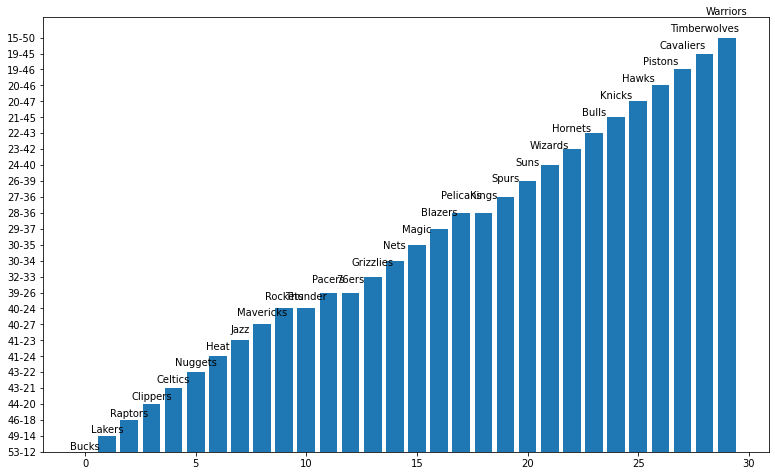

1     0.815385
2     0.777778
3     0.718750
4     0.687500
5     0.671875
6     0.661538
7     0.630769
8     0.640625
9     0.597015
10    0.625000
11    0.625000
12    0.600000
13    0.600000
14    0.492308
15    0.468750
16    0.461538
17    0.439394
18    0.437500
19    0.437500
20    0.428571
21    0.400000
22    0.375000
23    0.353846
24    0.338462
25    0.318182
26    0.298507
27    0.303030
28    0.292308
29    0.296875
30    0.230769
Name: Unnamed: 2, dtype: float64